<img src="https://github.com/FIUBA-Posgrado-Inteligencia-Artificial/procesamiento_lenguaje_natural/raw/main/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Word2vect

TP2: Bot Simple.

Juan Pablo Nieto Uribe

juanpablonietou@gmail.com

Contexto: La idea del desarrollo de mi TP2 es desarrollar un buscador muy primitivo que permita encontrar rápidamente en dónde dice una frase específica (o parecida) en una serie de archivos PDF, que en este caso son 3 papers seleccionados. 

Estos papers corresponden a la revisión de literatura de mi tesis de grado en Ingeniería Civil, en donde pasé mucho tiempo releyendo papers, a fin de encontrar el lugar exacto donde se daba algún argumento por no recordar las palabras exactas. 

Un ejemplo de esto es querer buscar la frase 'Muslim flyers', en donde la frase me hablaba de muslim travelers.

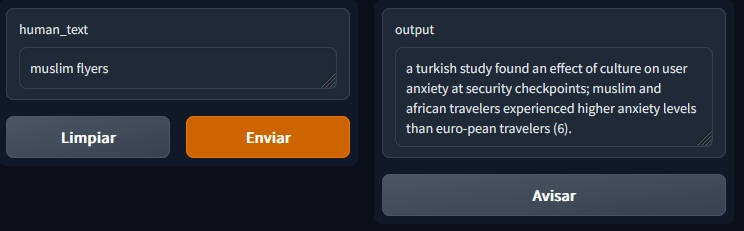

In [2]:
#!pip install wikipedia
!pip install PyPDF2
!pip install textract
!pip install gradio
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 217 kB 4.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 3.7 MB/s 
     |████████████████████████████████| 106 kB 31.2 MB/s 
     |████████████████████████████████| 32.8 MB 1.3 MB/s 
     |████████████████████████████████| 5.6 MB 49.6 MB/s 
     |████████████████████████████████| 10.1 MB 28.6 MB/s 
     |████████████████████████████████| 103 kB 61.3 MB/s 
     |████████████████████████████████| 2.3 MB 43.2 MB/s 
     |████████████████████████████████| 128 kB 49.0 MB/s 
     |████████████████████████████████| 73 kB 2.9 MB/s 
     |████████████████████████████████| 112 kB 51.0 MB/s 
     |████████████████████████████████| 149 kB 50.6 MB/s 
     |████████████████████████████████| 70 kB 8.1 MB/s 
     |████████████████████████████████| 336 kB 57.2 MB

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.1 MB 5.1 MB/s 
     |████████████████████████████████| 57 kB 5.5 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 112 kB 61.4 MB/s 
     |████████████████████████████████| 212 kB 43.3 MB/s 
     |████████████████████████████████| 270 kB 60.2 MB/s 
     |████████████████████████████████| 84 kB 3.8 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 84 kB 3.7 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 80 kB 9.1 MB/s 
     |████████████████████████████████| 68 kB 6.7 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 594 kB 52.9 MB/s 
     |████████████████████████████████| 856 kB 47.2 MB/s 
     |████████████████████████████████| 4.0 MB 44.

In [1]:
import json
import random
import re
import PyPDF2
import textract
#import wikipedia
import glob
import os
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import urllib.request
import numpy as np
import bs4 as bs
from nltk.stem import WordNetLemmatizer
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import gradio as gr

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

1. Datos:

Vamos a cargar 3 archivos en PDF desde Drive. Estos archivos corresponden a papers que hablan sobre satisfacción de usuarios en aeropuertos.

Antes de comenzar el análisis, revisamos cuántos archivos de tipo PDF hay en la carpeta.

In [7]:
mypath='/content'
arr=os.listdir(mypath)
num_archivos_pdf=len([f for f in os.listdir(mypath) 
     if f.endswith('.pdf') and os.path.isfile(os.path.join(mypath, f))])
print('En esta carpeta hay',num_archivos_pdf,'archivos pdf')

En esta carpeta hay 3 archivos pdf


Inicializamos nuestro corpus vacío

In [8]:
corpus=[]

Comenzamos la lectura de los archivos PDF

In [9]:
#Si quiero revisar todos los archivos en una ruta, hago camino_glob=r'*.pdf'
camino_glob1=r'*.pdf'
files=glob.glob(camino_glob1)
print(files)

['0_Eboli_Mazulla_2009_An Ordinal Logistic Regression Model for Analysing Airport Passenger Satisfaction.pdf', '0_Smahel_2017_Airport Features Most Likely to Affect International Traveler Satisfaction.pdf', "Fodness_Murray_2007_Passengers' Expectations of Airport Service Quality.pdf"]


In [10]:
for documento in enumerate(files):
  filename=documento[1]
  pdfFileObj=open(filename,'rb')
  pdfReader=PyPDF2.PdfFileReader(pdfFileObj)

  num_pages=pdfReader.numPages
  indice_Pagina_Leida=0
  linea=""

  while indice_Pagina_Leida<num_pages:
    page_Obj=pdfReader.getPage(indice_Pagina_Leida)
    indice_Pagina_Leida+=1
    linea+=page_Obj.extract_text()
  
  corpus.append(linea)

In [13]:
stop_words=stopwords.words('english')

In [14]:
print(len(stop_words))

179


In [21]:
print(len(corpus[0]))

57222


In [ ]:
#Juntamos todos los elementos del corpus y leemos de ahí
corpusJuntado=''
for corpusJuntator in range(len(corpus)):
  corpusJuntado=corpusJuntado+corpus[corpusJuntator]

corpusJuntado=corpusJuntado.lower()
print(corpusJuntado)

2. Preprocesamiento

Dado que ya tenemos una variable con todo el texto de los 3 documentos, vamos a hacer su preprocesamiento

In [49]:
texto = re.sub(r'\[[0-9]*\]', ' ', corpusJuntado)
texto = re.sub(r'\[(0-9)*\]', ' ', texto)
texto = re.sub(r'\[ crossref ]*\]', ' ', texto)
texto = re.sub(r'\[crossref ]*\]', ' ', texto)
texto = re.sub(r'\[ abstract ]*\]', ' ', texto)
texto = re.sub(r'\[abstract ]*\]', ' ', texto)
texto = re.sub(r'\[full text ]*\]', ' ', texto)
texto = re.sub(r'\[pdf]*\]', ' ', texto)
texto = re.sub(r'\downloaded by universidad de los andes colombia at 23:09 11 january 2018 (pt)*\]', ' ', texto)
texto = re.sub(" \d+", " ", texto)
texto = re.sub(r'\s+', ' ', texto)

In [50]:
print(texto)

euromed journal of business an ordinal logistic regression model for analysing airport passenger satisfaction laura eboli, gabriella mazzulla, article information: to cite this document: laura eboli, gabriella mazzulla, (2009) "an ordinal logistic regression model for analysing airport passenger satisfaction", euromed journal of business, vol. issue: , pp.40-57, https:// doi.org/10.1108/14502190910956684 permanent link to this document: https://doi.org/10.1108/14502190910956684 downloaded on: january , at: :50 (pt) references: this document contains references to other documents. to copy this document: permissions@emeraldinsight.com the fulltext of this document has been downloaded times since * users who downloaded this article also downloaded: (2007),"passengers' expectations of airport service quality", journal of services marketing, vol. iss pp. -506 <a href="https://doi.org/10.1108/08876040710824852">https:// doi.org/10.1108/08876040710824852</a> (2013),"airport service quality dr

Dividimos el texto en sentencias y palabras

In [51]:
corpus_b=nltk.sent_tokenize(texto)
svarder=nltk.word_tokenize(texto)

In [52]:
corpus_b[:10]

['euromed journal of business an ordinal logistic regression model for analysing airport passenger satisfaction laura eboli, gabriella mazzulla, article information: to cite this document: laura eboli, gabriella mazzulla, (2009) "an ordinal logistic regression model for analysing airport passenger satisfaction", euromed journal of business, vol.',
 'issue: , pp.40-57, https:// doi.org/10.1108/14502190910956684 permanent link to this document: https://doi.org/10.1108/14502190910956684 downloaded on: january , at: :50 (pt) references: this document contains references to other documents.',
 'to copy this document: permissions@emeraldinsight.com the fulltext of this document has been downloaded times since * users who downloaded this article also downloaded: (2007),"passengers\' expectations of airport service quality", journal of services marketing, vol.',
 'iss pp.',
 '-506 <a href="https://doi.org/10.1108/08876040710824852">https:// doi.org/10.1108/08876040710824852</a> (2013),"airport

In [53]:
svarder[:20]

['euromed',
 'journal',
 'of',
 'business',
 'an',
 'ordinal',
 'logistic',
 'regression',
 'model',
 'for',
 'analysing',
 'airport',
 'passenger',
 'satisfaction',
 'laura',
 'eboli',
 ',',
 'gabriella',
 'mazzulla',
 ',']

4. Funciones de ayuda para limpiar y procesar el imput del usuario

Ahora podemos  entrar a limpiar el texto.

In [55]:
lematizador=WordNetLemmatizer()

def perform_lemmatization(tokens):
    return [lematizador.lemmatize(token) for token in tokens]

punctuation_removal = dict((ord(punctuation), None) for punctuation in string.punctuation)

def get_processed_text(document):
  return perform_lemmatization(nltk.word_tokenize(document.lower().translate(punctuation_removal)))


5. Utilizamos vectortes TF-IDF y la similitud coseno construido con el corpus de nuestros papers

In [57]:
def generate_response(user_input, corpus):
    response = ''
    # Sumar al corpus la pregunta del usuario para calcular
    # su cercania con otros documentos/sentencias
    # la entrada del usuario se usa para tokenizar y vectorizar
    corpus.append(user_input)

    # Crear un vectorizar TFIDF que quite las "stop words" del ingles y utilice
    # nuestra funcion para obtener los tokens lematizados "get_processed_text"
    word_vectorizer = TfidfVectorizer(tokenizer=get_processed_text, stop_words='english')

    # Crear los vectores a partir del corpus
    all_word_vectors = word_vectorizer.fit_transform(corpus)

    # Calcular la similitud coseno entre todas los documentos excepto el agregado (el útlimo "-1")
    # NOTA: con los word embedings veremos más en detalle esta matriz de similitud
    similar_vector_values = cosine_similarity(all_word_vectors[-1], all_word_vectors)

    # Obtener el índice del vector más cercano a nuestra oración
    # --> descartando la similitud contra nuestor vector propio
    similar_sentence_number = similar_vector_values.argsort()[0][-2]
    matched_vector = similar_vector_values.flatten()
    matched_vector.sort()
    vector_matched = matched_vector[-2]

    if vector_matched == 0: # si la similaridad coseno fue nula (ningún término en común)
        #Lo cambié para asegurarme que esté todo check
        response = "Förlåt. Jag förstår inte"
    else:
        response = corpus[similar_sentence_number] # obtener el documento del corpus más similar
    
    corpus.remove(user_input)
    return response

In [56]:
# Se utilizará gradio para ensayar el bot
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
import sys
!{sys.executable} -m pip install gradio --quiet

In [ ]:
def bot_response(human_text):
    print("Q:", human_text)    
    resp = generate_response(human_text.lower(), corpus_b)
    print("A:", resp)
    return resp

iface = gr.Interface(
    fn=bot_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `layout` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://22186.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces: https://huggingface.co/spaces


Q: Workers at an airport should be knowledgeable about local areas of interest


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  % sorted(inconsistent)


A: restaurants,restrooms, and shops) should be conveniently locatednear gates and in every terminal.16 it is important to me for the public announcement /paging system to be audible in all areas of an airportterminal, including restaurants, retail stores, andcurbside check-in.17 i feel airports should have more ﬂight informationdisplays in the terminals.18 a variety of food choices should be available at airports.19 i ﬁnd electric passenger transfer carts to be convenientwhen changing planes.20 there should be an automated means of obtaininginformation on local attractions at an airport.21opportunities to enjoy the local cuisine should be available atairports.22nationally known retail outlets should be available atairports.23it upsets me when i have to wait more than ten minutes toreceive my baggage after a ﬂight.24 i should be able to walk to the parking lot from theterminal at an airport.25 children’s play areas should be available in airportterminals.26 an airport’s terminal should 